# Stacked LSTM

## Keras version

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import random

In [14]:
model = Sequential()
# (timesteps, input_dim)
model.add(LSTM(1, input_shape=(3, 1)))
model.compile(optimizer='adam', loss='mse')
data = np.array([0.1, 0.2, 0.3]).reshape((1, 3, 1))
# (nb_samples, output_dim)
result = model.predict(data)
print(result.shape)

(1, 1)


- KerasのデフォルトのLSTMは入力系列の各要素に対する出力は出さない（最後の出力のみ）
- return_sequences=Trueとすると入力系列の各要素に対する出力をだす
- Stacked LSTMの下の層は入力系列の各要素に対する出力を出す必要がある

In [17]:
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(3, 1)))
model.compile(optimizer='adam', loss='mse')
data = np.array([0.1, 0.2, 0.3]).reshape((1, 3, 1))
result = model.predict(data)
print(result.shape)

(1, 3, 1)


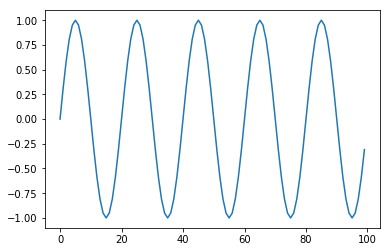

In [19]:
import math
import matplotlib.pyplot as plt

length = 100
freq = 5
sequence = [math.sin(2 * math.pi * freq * (i / length)) for i in range(length)]

plt.plot(sequence)
plt.show()

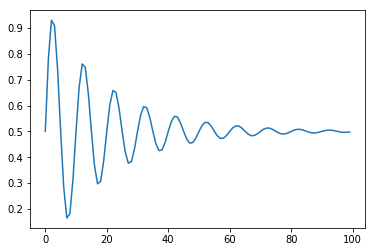

In [22]:
length = 100
period = 10
decay = 0.05
sequence = [0.5 + 0.5 * math.sin(2 * math.pi * i / period) * math.exp(-decay * i) for i in range(length)]
plt.plot(sequence)
plt.show()

In [23]:
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * math.sin(2 * math.pi * i / period) * math.exp(-decay * i) for i in range(length)]

In [31]:
def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for _ in range(n_patterns):
        p = random.randint(10, 20)
        d = random.uniform(0.01, 0.1)
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    # input: (nb_samples, timesteps, input_dim)
    X = np.array(X).reshape(n_patterns, length, 1)
    # output: (nb_samples, output_dim)
    y = np.array(y).reshape(n_patterns, output)
    return X, y

In [32]:
X, y = generate_examples(20, 5, 5)
print(X.shape, y.shape)

(5, 20, 1) (5, 5)


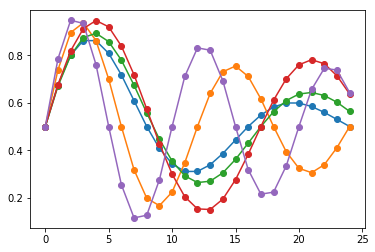

In [33]:
for i in range(len(X)):
    plt.plot([x for x in X[i, :, 0]] + [x for x in y[i]], '-o')

- many-to-one として実装するのがポイント
- 長さnの系列を出力するのではなく、長さが1でn次元の特徴をもつ系列を予測する
- 1次元の特徴量で長さnの系列を出力するアーキテクチャにすることもできる

In [42]:
length = 50
output = 5

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50, 20)            1760      
_________________________________________________________________
lstm_29 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________


In [44]:
X, y = generate_examples(length, 10000, output)
model.fit(X, y, batch_size=10, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 65s 7ms/step - loss: 0.0479


In [45]:
X, y = generate_examples(length, 1000, output)
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

MAE: 0.023083


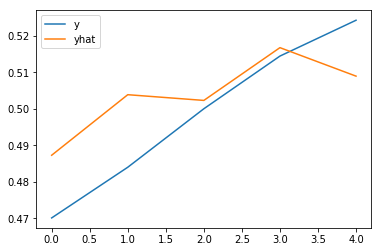

In [46]:
X, y = generate_examples(length, 1, output)
yhat = model.predict(X, verbose=0)
plt.plot(y[0], label='y')
plt.plot(yhat[0], label='yhat')
plt.legend()
plt.show()